<a href="https://colab.research.google.com/github/MartsenkoVS/Kyokushinkai_audio_classification/blob/main/Model_training_(Librosa).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!pip install pydub

In [ ]:
import os
import librosa
from pydub import AudioSegment
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
import wave
import soundfile as sf

import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Подготовка аудио-датасета:

## Нарезка аудио и разбивка по лейблам

In [ ]:
# функция для вырезания аудио из всех видео в папке:
def audio_from_video(video_folder_path, audio_folder_path):
  # в папке с видео создаем папку для аудио
  os.makedirs(audio_folder_path, exist_ok=True)
  os.chdir(audio_folder_path)

  # Проходим по всем директориям и файлам в директории
  for root, dirs, files in os.walk(video_folder_path):
    for file in files:
      if file.endswith('.mp4') | file.endswith('.mov'): # указать форматы видеофайла
        video_path = os.path.join(root, file)
        video = moviepy.editor.VideoFileClip(video_path)
        video.audio.write_audiofile(f'{(file)[:-4]}.wav')


video_folder_path = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/25-04-2024'
audio_folder_path = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/25-04-2024/audio'

audio_from_video(video_folder_path, audio_folder_path)

In [ ]:
# Переводим аудио в формат wav:
def wav_from_audio(audio_folder_path):
  wav_folder_path = os.path.join(audio_folder_path, 'wav')
  os.makedirs(wav_folder_path, exist_ok=True)
  os.chdir(wav_folder_path)

  for file_name in os.scandir(audio_folder_path):
    if file_name.is_file() and file_name.name.endswith('.mp3') | file_name.name.endswith('.ogg'): # указать форматы аудио
      audio = AudioSegment.from_file(file_name)
      audio.export(f'{(file_name.name)[:-4]}.wav', format="wav")

wav_from_audio('/content/drive/MyDrive/Стажировка "Кёкусинкай"/Сами записали')

In [ ]:
# подготавливаем данные для dataframe
# функция сопоставляет аудио и txt файл с метками по названию, и создает dataframe c метками и лейблами
def dataframe_from_audio(audio_folder_path, timestamps_folder_path):
  audio_data_list = []
  os.chdir(timestamps_folder_path)
  for audio_file in os.scandir(audio_folder_path):
    if audio_file.is_file() and audio_file.name.endswith('.wav'):
      audio_id = audio_file.name[:-4]  # id для поиска нужного txt файла с разметкой
      audio_path = audio_file.path
      for txt_name in os.scandir(timestamps_folder_path):
        if txt_name.is_file() and txt_name.name.endswith('.txt') and txt_name.name[:-4] == audio_id:
          with open (txt_name.name, 'r') as f:
            for line in f:
              timestamps = line.split('\t')   # метки времени кличей/команд
              audio_data = {'audio_id': audio_id,
                            'audio_path': audio_path,
                            'start_time': float(timestamps[0]),
                            'stop_time': float(timestamps[1]),
                            'label': timestamps[2][:-1].lower().replace(" ", "")
                            }
              audio_data_list.append(audio_data)
  audio_df = pd.DataFrame(audio_data_list)
  return audio_df

In [ ]:
# Пример одной строки в dataframe
audio_data_list[0]

{'audio_id': '20240209_181457',
 'audio_path': '/content/drive/MyDrive/Стажировка "Кёкусинкай"/Камера_1/audio/20240209_181457.wav',
 'start_time': 5.683204,
 'stop_time': 6.392208,
 'label': 'Осс'}

In [ ]:
# Создаем dataframe
audio_folder_path = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/25-04-2024/audio'
timestamps_folder_path = os.path.join(audio_folder_path, 'timestamps')

audio_df = dataframe_from_audio(audio_folder_path, timestamps_folder_path)

In [ ]:
# Исправляем названия лейблов
audio_df.label[(audio_df.label == 'осс') | (audio_df.label == 'os')] = 'oss'
audio_df.label[(audio_df.label == 'тайкёкусоноичи') | (audio_df.label == 'тайичи')] = 'kato1'
audio_df.label[(audio_df.label == 'тайкёкусонони') | (audio_df.label == 'тайни')] = 'kato2'
audio_df.label[(audio_df.label == 'тайкёкусоносан') | (audio_df.label == 'тайсан')] = 'kato3'
audio_df.label[audio_df.label == 'пинансоноичи'] = 'kato4'
audio_df.label[(audio_df.label == 'хаджимэ') | (audio_df.label == 'hadg')] = 'hadgime'
audio_df.label[(audio_df.label == 'кияй') | (audio_df.label == 'kia')] = 'kiai'
audio_df.label[audio_df.label == 'наурэ'] = 'naure'

# Удаляем ненужный label
audio_df = audio_df.query("label != 'пинансонони!!!'")

# Сброс индексов
audio_df = audio_df.reset_index(drop=True)

In [ ]:
audio_df

,audio_id,audio_path,start_time,stop_time,label
0,20240425_191040,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",9.754877,10.940489,kato4
1,20240425_191040,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",10.940489,12.058616,kato4
2,20240425_190541_,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",11.492144,12.315838,kato4
3,20240425_190541_,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",12.513436,13.344649,kato4
4,20240425_190809,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",13.808792,14.909847,kato3
...,...,...,...,...,...
141,Тайкёку соно сан.,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",10.354116,11.446768,kato3
142,Тайкёку соно сан.,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",11.465102,12.272185,kato3
143,Тайкёку соно сан..2,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",8.058509,9.040797,kato3
144,Тайкёку соно сан2,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",12.357826,13.259823,kato3


In [ ]:
# проверяем количество примеров по лейблам:
audio_df.groupby(['label']).audio_id.count()

In [ ]:
# Статистика меток по видео
audio_df.groupby(['audio_id']).audio_id.count()

In [ ]:
# Функция нарезает аудио в соотвтетствии с разметкой, и сохраняет в папку с названием лейбла:
def cut_audio_from_df(audio_df, sliced_audio_folder_path):
  for index, row in audio_df.iterrows():
      # Загрузка аудио файла
      audio_path = row['audio_path']
      audio = AudioSegment.from_file(audio_path)

      # Переводим в моносигнал
      audio = audio.set_channels(1)
      # Изменение частоты дискретизации на 16000 Гц
      audio = audio.set_frame_rate(16000)

      # Преобразование временных меток в миллисекунды
      start_ms = row['start_time'] * 1000
      end_ms = row['stop_time'] * 1000

      # Вырезание сегмента
      segment = audio[start_ms:end_ms]

      # Формирование пути для сохранения с учетом метки
      label_folder_path = os.path.join(sliced_audio_folder_path, row['label'])
      os.makedirs(label_folder_path, exist_ok=True)
      sliced_audio_name = f"{row['audio_id']}_{index}.wav"
      sliced_audio_path = os.path.join(label_folder_path, sliced_audio_name)

      # Сохранение аудио сегмента
      segment.export(sliced_audio_path, format="wav")

      print(f"Сегмент сохранен: {sliced_audio_path}")


sliced_audio_folder_path = os.path.join(audio_folder_path, 'sliced_audio')
cut_audio_from_df(audio_df, sliced_audio_folder_path)

## Подрезка тишины до и после клича

In [ ]:
# Функция создает новую директорию на уровень выше
def create_directory_above(input_dir, new_dir_name):
    #Определяем путь на уровень выше
    parent_dir = os.path.dirname(input_dir)
    # Путь для новой директории
    new_dir_path = os.path.join(parent_dir, new_dir_name)
    # Создаем новую директорию
    os.makedirs(new_dir_path, exist_ok=True)
    return new_dir_path

In [ ]:
# Функция подрезает тишину до и после клича в аудио
def trim_and_save_audio(dataset_dir, top_db=20):
  # Создаем новую директорию для "подрезанного" датасета
  new_dir_name = 'trimmed_dataset'
  new_dir_path = create_directory_above(dataset_dir, new_dir_name)

  for label in os.listdir(dataset_dir):
    audio_folder = os.path.join(dataset_dir, label)
    for audio_name in os.listdir(audio_folder):
      audio_path = os.path.join(audio_folder, audio_name)

      # Приводим аудио к моноканалу и частоте дисретизации 16000
      y, sr = librosa.load(audio_path, sr=16000)
      # Подрезаем тишину
      y_trimmed, _ = librosa.effects.trim(y, top_db=top_db)
      new_audio_folder = os.path.join(new_dir_path, label)
      os.makedirs(new_audio_folder, exist_ok=True)
      os.chdir(new_audio_folder)
      # Сохраняем новое аудио
      sf.write(audio_name, y_trimmed, sr)

In [ ]:
dataset_dir = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/Dataset_audio_final'
trim_and_save_audio(dataset_dir)

## Определение выбросов в датасете:

Выбросы (или аномалии) в данных представляют собой наблюдения, которые существенно отличаются от остальных данных. Для аудиофайлов можно использовать различные характеристики для определения выбросов, такие как:

**Duration (Длительность):**
Длительность аудиофайла в секундах.
Аудиофайлы с необычно короткой или длинной длительностью могут считаться выбросами. Например, если у вас есть категория, где все файлы имеют длительность около 1 секунды, но один файл имеет длительность 10 секунд, это может быть выбросом.

**RMS Energy (Энергия RMS):**
Среднеквадратичная амплитуда звукового сигнала.
Этот показатель отражает среднюю громкость аудиофайла. Аудиофайлы с очень низкой или очень высокой энергией могут быть выбросами. Например, если у вас есть файл с очень низкой громкостью по сравнению с остальными, он может считаться выбросом.

**Spectral Centroid (Спектральный центроид):**
Центр массы спектра аудиофайла, который воспринимается как "яркость" звука.
Аудиофайлы с очень низким или высоким спектральным центроидом могут быть выбросами. Например, если файл имеет значительно более высокий спектральный центроид, чем остальные, это может указывать на аномально высокие частоты в файле.

**Zero Crossing Rate (Частота пересечения нуля):**
Количество раз, когда звуковой сигнал пересекает ось нуля.
Этот показатель может быть высоким для шумов или сигналов с большим количеством высокочастотных компонентов. Аудиофайлы с аномально высокой или низкой частотой пересечения нуля могут считаться выбросами.


*Определение выбросов*

Для определения выбросов в наборе данных мы используем алгоритм Isolation Forest. Этот алгоритм работает следующим образом:

**Isolation Forest:**
Алгоритм строит множество деревьев решений, где каждое дерево случайным образом выбирает признак и значение для разделения данных.
Цель состоит в изоляции каждого наблюдения. Чем меньше шагов требуется для изоляции наблюдения, тем более вероятно, что оно является выбросом.
Преимущество этого метода заключается в том, что он не требует предположений о распределении данных и может обнаруживать выбросы в многомерных данных.

Как это работает в нашем коде

*Извлечение характеристик:*

Для каждого аудиофайла мы извлекаем характеристики (длительность, RMS энергию, спектральный центроид, частоту пересечения нуля) с помощью функции extract_features.

*Масштабирование характеристик:*

Мы масштабируем характеристики, чтобы они имели нулевое среднее и единичное стандартное отклонение. Это необходимо для корректной работы алгоритма Isolation Forest.

*Обнаружение выбросов:*

Мы используем алгоритм Isolation Forest для классификации каждого аудиофайла как нормального (предсказание 1) или выброса (предсказание -1).

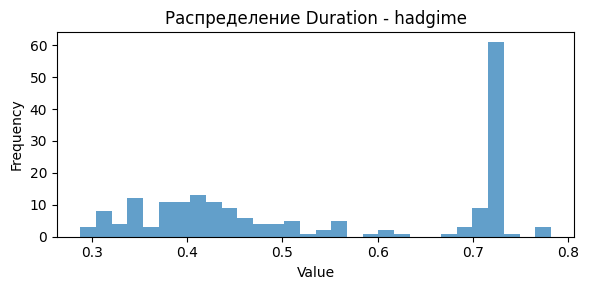

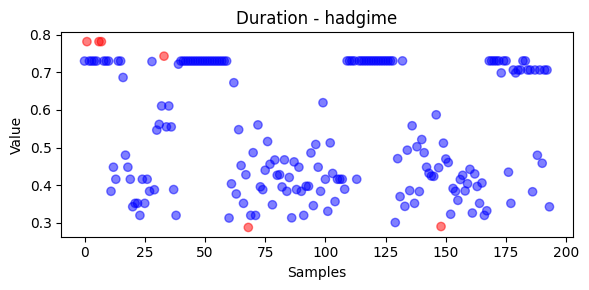

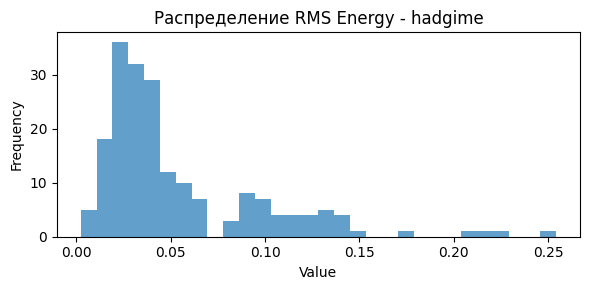

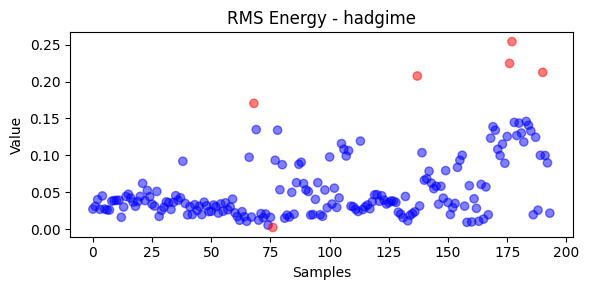

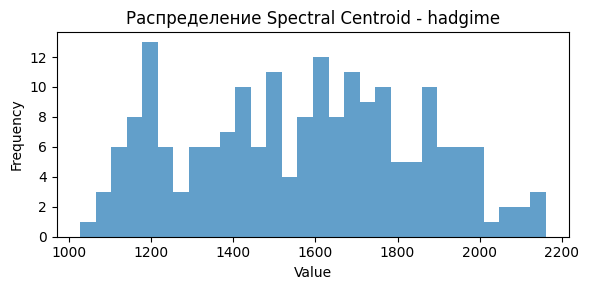

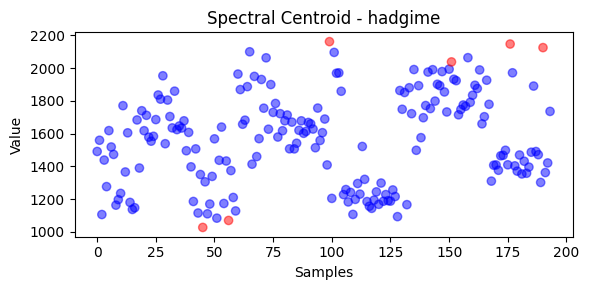

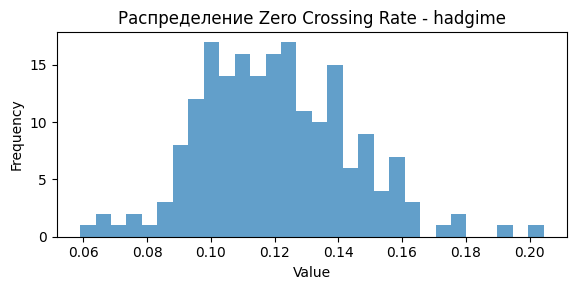

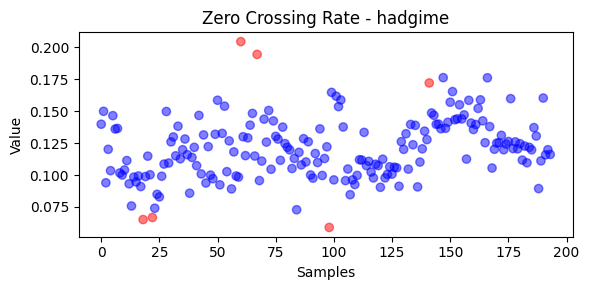


Категория: hadgime
  Всего файлов: 194
  Выбросов по признакам: 21
  Выброс обнаружен: hadgime/20240209_182010_58.wav
  Выброс обнаружен: hadgime/20240209_182207_30.wav
  Выброс обнаружен: hadgime/20240209_182113_44.wav
  Выброс обнаружен: hadgime/20.wav
  Выброс обнаружен: hadgime/10.wav
  Выброс обнаружен: hadgime/3_705.wav
  Выброс обнаружен: hadgime/20240209_183346_3_156.wav
  Выброс обнаружен: hadgime/20240209_182727_3_212.wav
  Выброс обнаружен: hadgime/fourth_1032.wav
  Выброс обнаружен: hadgime/fourth_1004.wav
  Выброс обнаружен: hadgime/five_n_1242.wav
  Выброс обнаружен: hadgime/first_894.wav
  Выброс обнаружен: hadgime/5.wav
  Выброс обнаружен: hadgime/second_957.wav
  Выброс обнаружен: hadgime/Сенсей Сиранчиев К.А. (3 дан, IFK) - Пинан соно ити_14.wav
  Выброс обнаружен: hadgime/third_829.wav
  Выброс обнаружен: hadgime/sixth_1109.wav
  Выброс обнаружен: hadgime/sixth_1088.wav
  Выброс обнаружен: hadgime/Тайкёку соно ити_2.wav
  Выброс обнаружен: hadgime/Сенсей Сиранчи

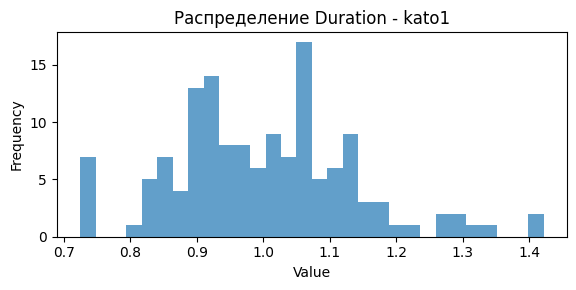

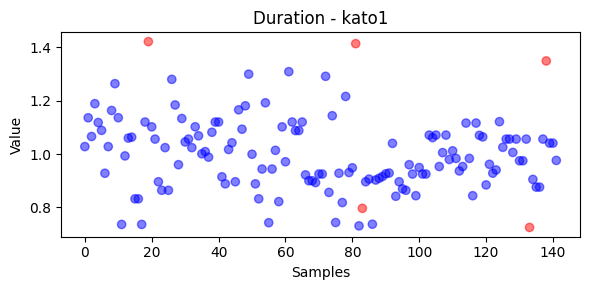

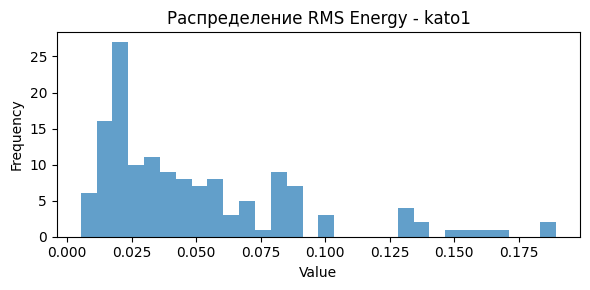

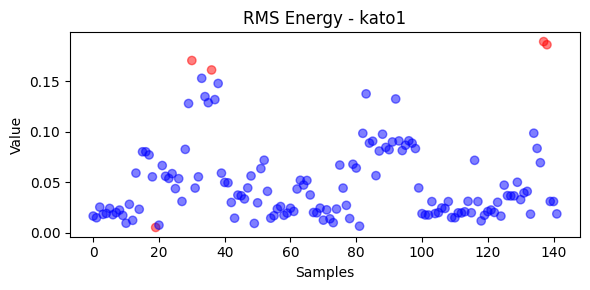

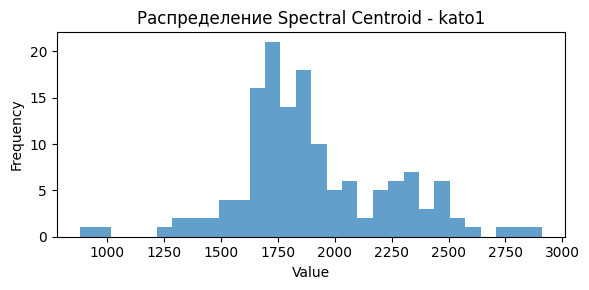

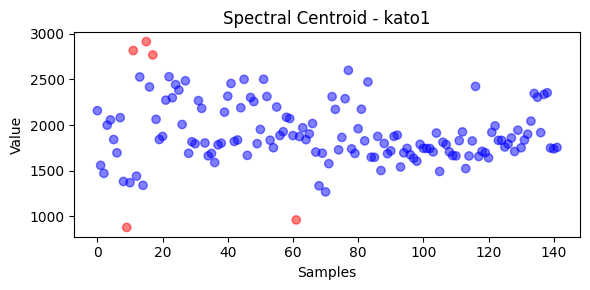

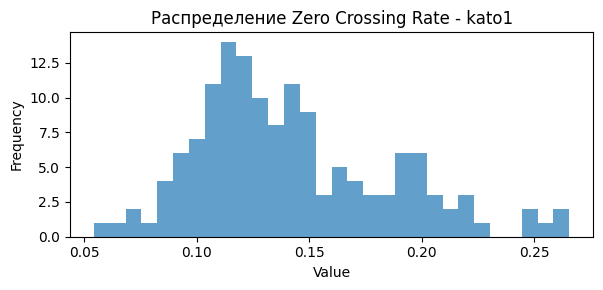

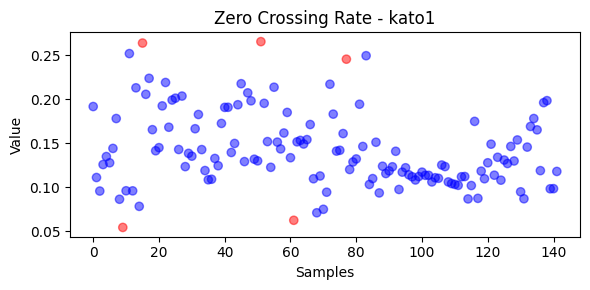


Категория: kato1
  Всего файлов: 142
  Выбросов по признакам: 15
  Выброс обнаружен: kato1/20240209_182011_190.wav
  Выброс обнаружен: kato1/2.wav
  Выброс обнаружен: kato1/19.wav
  Выброс обнаружен: kato1/18.wav
  Выброс обнаружен: kato1/0_558.wav
  Выброс обнаружен: kato1/audio_2024-04-22_15-31-00_161.wav
  Выброс обнаружен: kato1/audio_2024-04-22_15-31-00_139.wav
  Выброс обнаружен: kato1/2_677.wav
  Выброс обнаружен: kato1/20240209_182447_225.wav
  Выброс обнаружен: kato1/five_n_1240.wav
  Выброс обнаружен: kato1/fith_907.wav
  Выброс обнаружен: kato1/eight_n_1348.wav
  Выброс обнаружен: kato1/VID-20240426-WA0683_48.wav
  Выброс обнаружен: kato1/Тайкёку соно ити_0.wav
  Выброс обнаружен: kato1/Тайкёку соно ити_1.wav


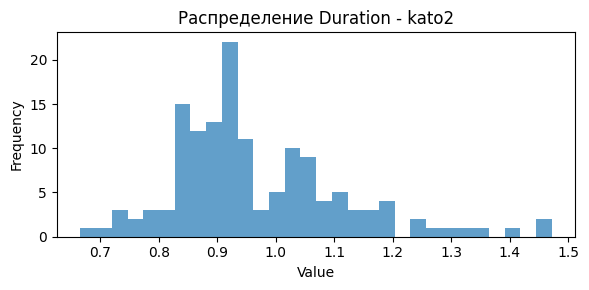

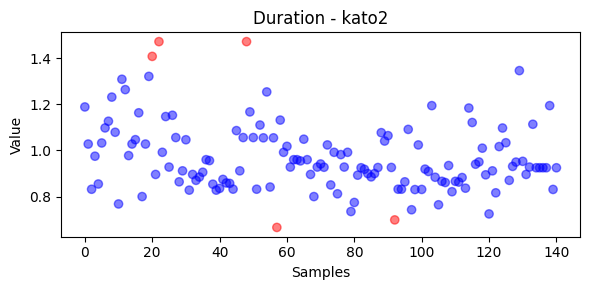

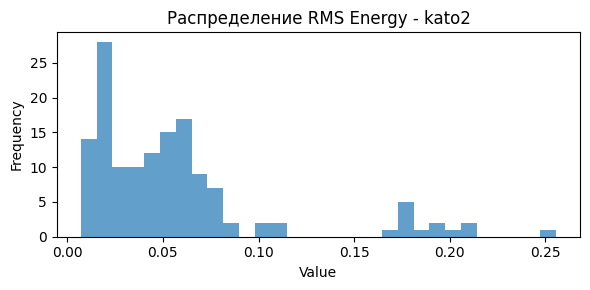

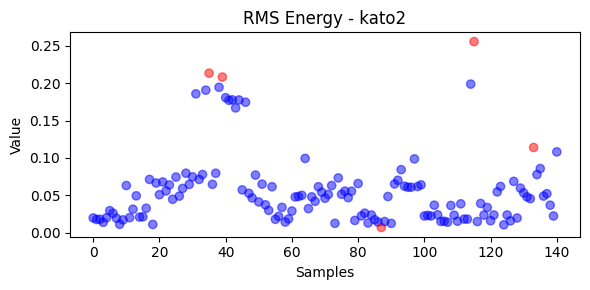

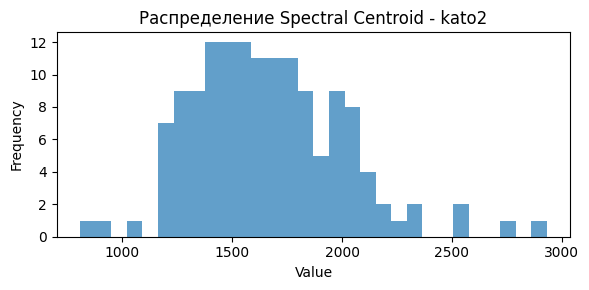

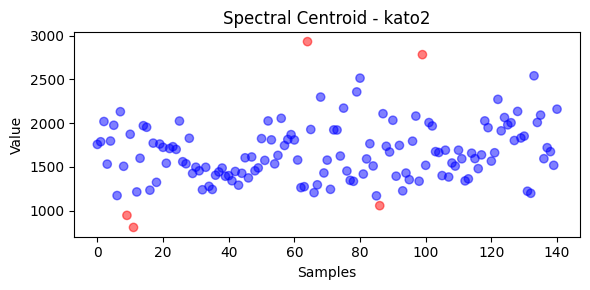

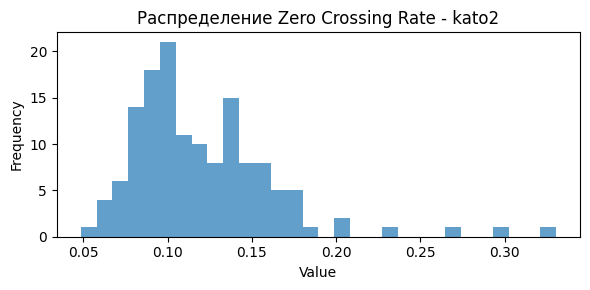

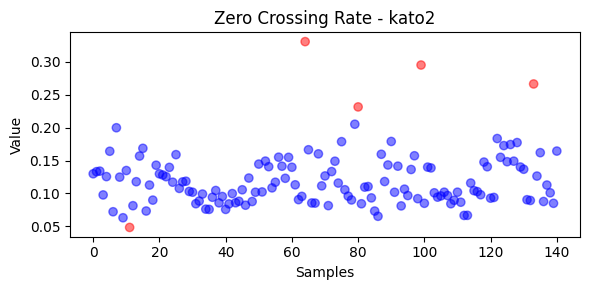


Категория: kato2
  Всего файлов: 141
  Выбросов по признакам: 16
  Выброс обнаружен: kato2/20240209_181633_176.wav
  Выброс обнаружен: kato2/20240209_182609_3_204.wav
  Выброс обнаружен: kato2/16.wav
  Выброс обнаружен: kato2/15.wav
  Выброс обнаружен: kato2/audio_2024-04-22_15-31-00_160.wav
  Выброс обнаружен: kato2/audio_2024-04-22_15-31-00_156.wav
  Выброс обнаружен: kato2/6.wav
  Выброс обнаружен: kato2/2_693.wav
  Выброс обнаружен: kato2/nine_n_1449.wav
  Выброс обнаружен: kato2/nine_n_1395.wav
  Выброс обнаружен: kato2/IMG_3477_476.wav
  Выброс обнаружен: kato2/fourth_1050.wav
  Выброс обнаружен: kato2/eight_n_1365.wav
  Выброс обнаружен: kato2/five_n_1247.wav
  Выброс обнаружен: kato2/Сенсей Сиранчиев К.А. (3 дан, IFK) - Тайкёку соно ни_8.wav
  Выброс обнаружен: kato2/ten_n_1110.wav


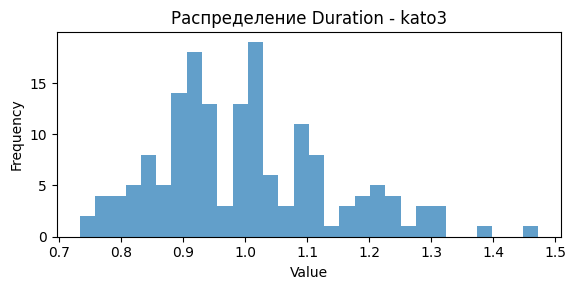

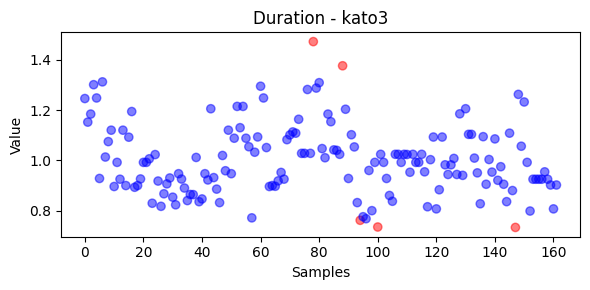

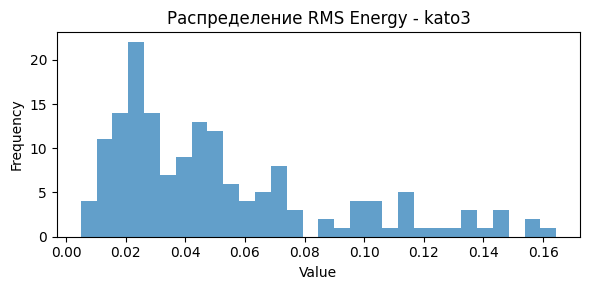

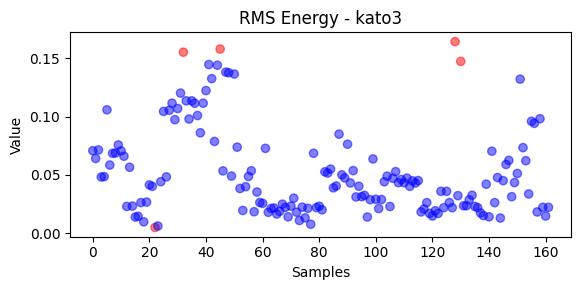

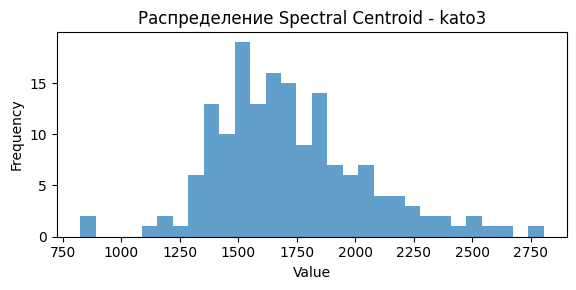

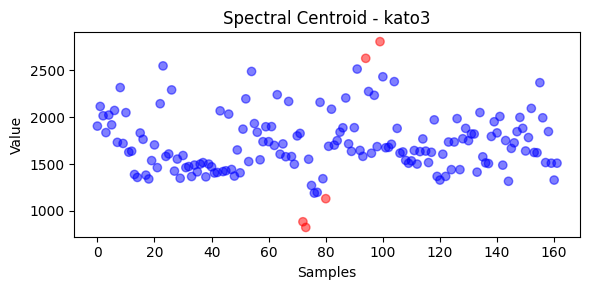

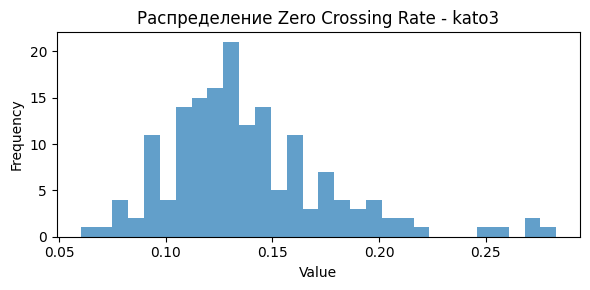

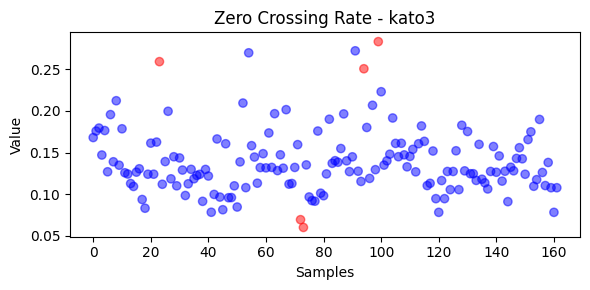


Категория: kato3
  Всего файлов: 162
  Выбросов по признакам: 15
  Выброс обнаружен: kato3/first_893.wav
  Выброс обнаружен: kato3/first_892.wav
  Выброс обнаружен: kato3/audio_2024-04-22_15-31-00_170.wav
  Выброс обнаружен: kato3/audio_2024-04-22_15-31-00_136.wav
  Выброс обнаружен: kato3/20240209_183758_3_267.wav
  Выброс обнаружен: kato3/20240209_183254_141.wav
  Выброс обнаружен: kato3/20.wav
  Выброс обнаружен: kato3/20240209_182727_3_211.wav
  Выброс обнаружен: kato3/six_n_1164.wav
  Выброс обнаружен: kato3/seven_n_1318.wav
  Выброс обнаружен: kato3/seven_n_1282.wav
  Выброс обнаружен: kato3/seven_n_1294.wav
  Выброс обнаружен: kato3/Сенсей Сиранчиев К.А. (3 дан, IFK) - Тайкёку соно сан_4.wav
  Выброс обнаружен: kato3/Сенсей Сиранчиев К.А. (3 дан, IFK) - Тайкёку соно сан_5.wav
  Выброс обнаружен: kato3/third_835.wav


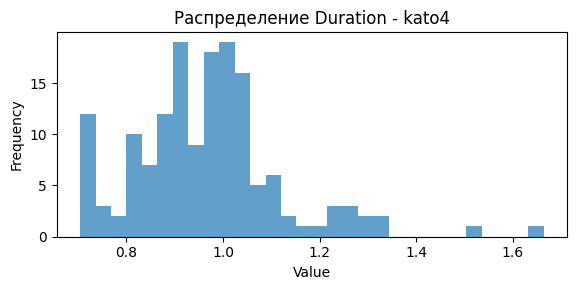

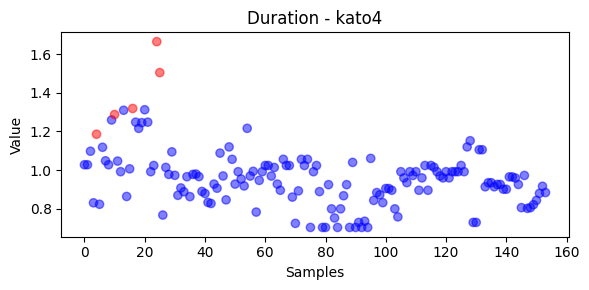

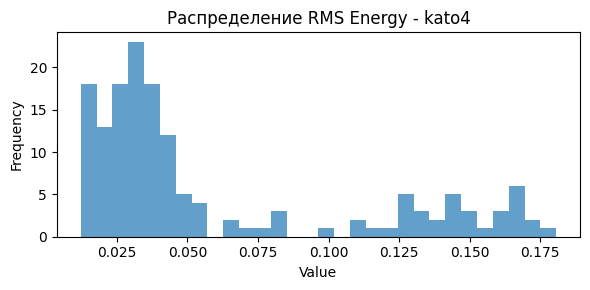

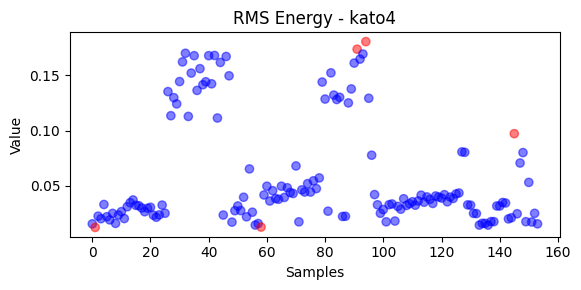

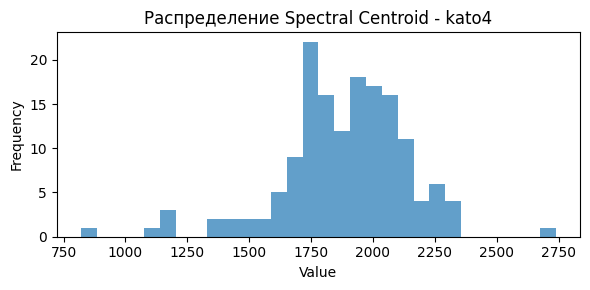

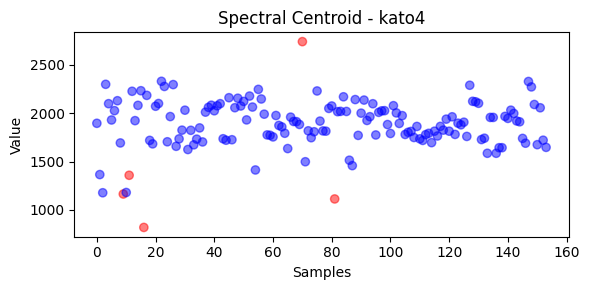

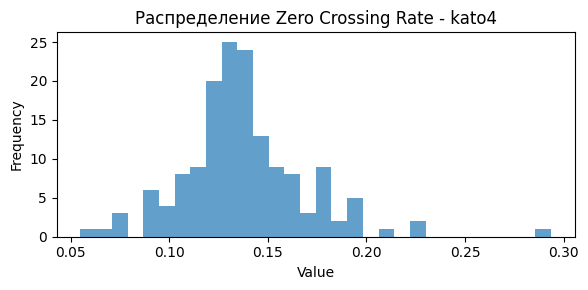

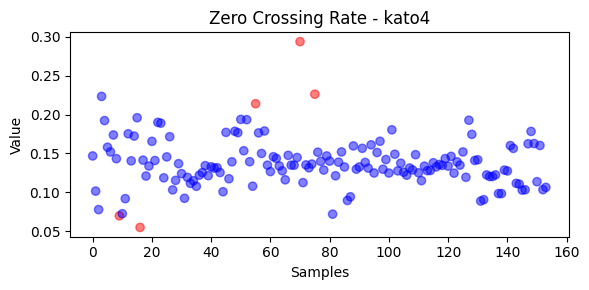


Категория: kato4
  Всего файлов: 154
  Выбросов по признакам: 16
  Выброс обнаружен: kato4/20240209_183856_127.wav
  Выброс обнаружен: kato4/20240425_191040_0.wav
  Выброс обнаружен: kato4/20240209_182825_3_260.wav
  Выброс обнаружен: kato4/20240209_181853_3_169.wav
  Выброс обнаружен: kato4/20240209_182331_36.wav
  Выброс обнаружен: kato4/20240209_182331_3_218.wav
  Выброс обнаружен: kato4/1.wav
  Выброс обнаружен: kato4/11.wav
  Выброс обнаружен: kato4/20240425_195154_34.wav
  Выброс обнаружен: kato4/20240425_194953_36.wav
  Выброс обнаружен: kato4/second_988.wav
  Выброс обнаружен: kato4/nine_n_1390.wav
  Выброс обнаружен: kato4/IMG_3475_462.wav
  Выброс обнаружен: kato4/audio_2024-04-22_15-31-06_122.wav
  Выброс обнаружен: kato4/audio_2024-04-22_15-31-06_124.wav
  Выброс обнаружен: kato4/Пинан соно ити 2_287.wav


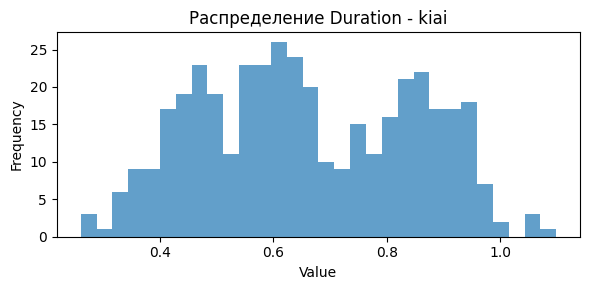

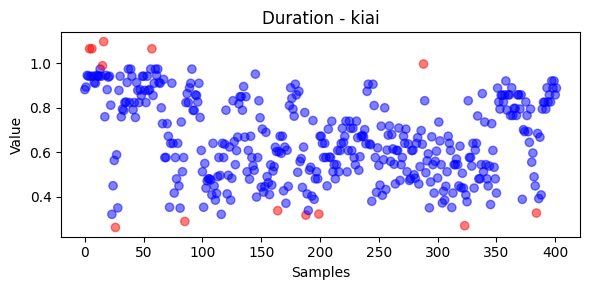

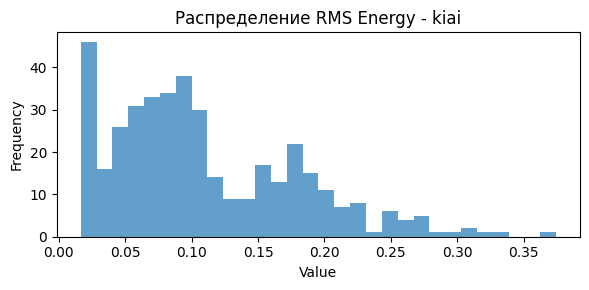

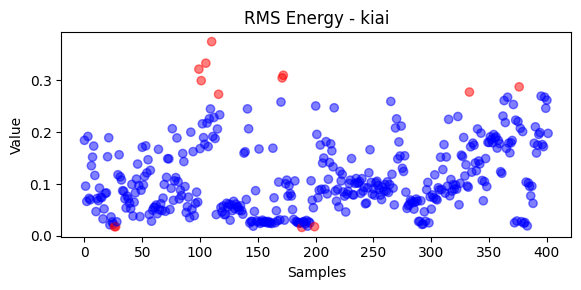

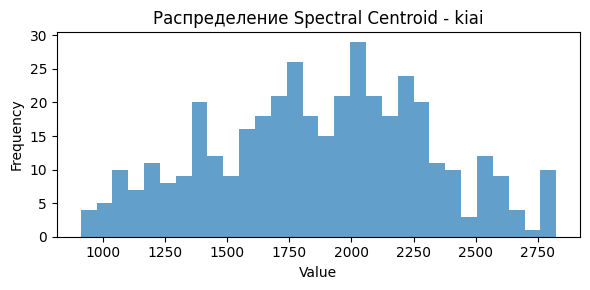

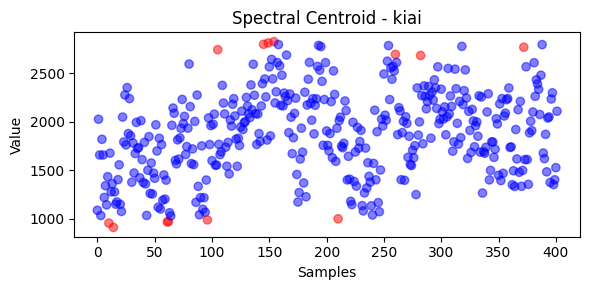

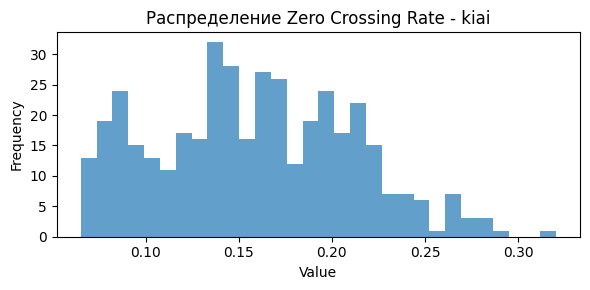

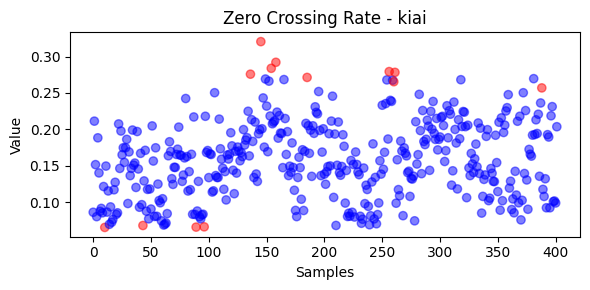


Категория: kiai
  Всего файлов: 402
  Выбросов по признакам: 43
  Выброс обнаружен: kiai/20240209_182113_46.wav
  Выброс обнаружен: kiai/20240209_182207_32.wav
  Выброс обнаружен: kiai/20240209_182011_193.wav
  Выброс обнаружен: kiai/20240209_182011_192.wav
  Выброс обнаружен: kiai/20240209_182010_59.wav
  Выброс обнаружен: kiai/20240209_182010_60.wav
  Выброс обнаружен: kiai/0_561.wav
  Выброс обнаружен: kiai/1_606.wav
  Выброс обнаружен: kiai/20240209_183254_143.wav
  Выброс обнаружен: kiai/20240209_182331_39.wav
  Выброс обнаружен: kiai/20240209_182609_3_207.wav
  Выброс обнаружен: kiai/20240209_182609_3_206.wav
  Выброс обнаружен: kiai/2_664.wav
  Выброс обнаружен: kiai/20240209_183758_3_270.wav
  Выброс обнаружен: kiai/20240209_183254_144.wav
  Выброс обнаружен: kiai/eight_n_1367.wav
  Выброс обнаружен: kiai/eight_n_1357.wav
  Выброс обнаружен: kiai/eight_n_1351.wav
  Выброс обнаружен: kiai/eight_n_1344.wav
  Выброс обнаружен: kiai/eight_n_1334.wav
  Выброс обнаружен: kiai/3_737.

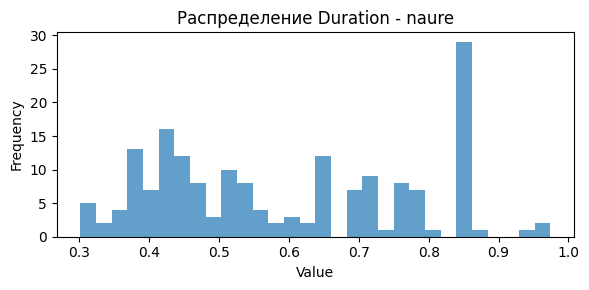

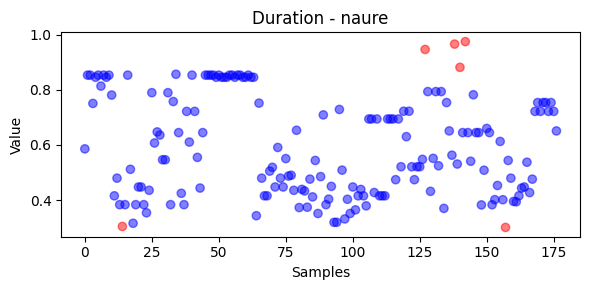

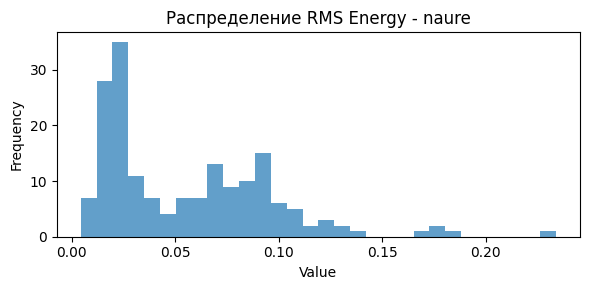

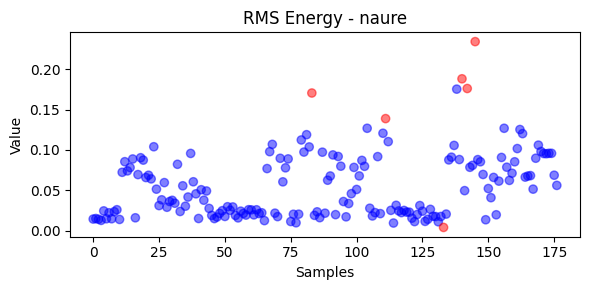

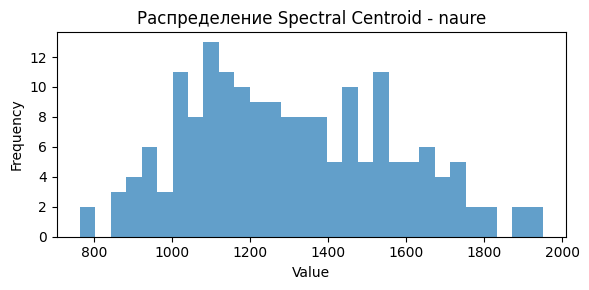

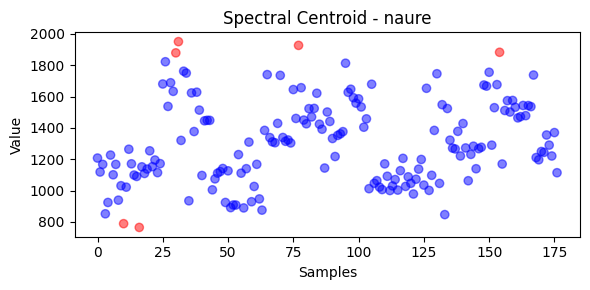

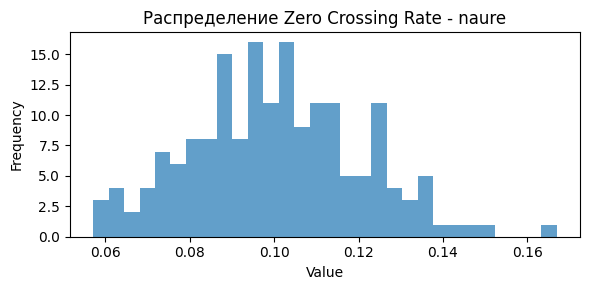

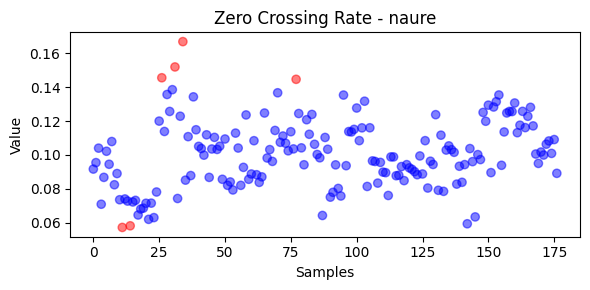


Категория: naure
  Всего файлов: 177
  Выбросов по признакам: 19
  Выброс обнаружен: naure/20240209_181458_166.wav
  Выброс обнаружен: naure/16.wav
  Выброс обнаружен: naure/17.wav
  Выброс обнаружен: naure/20240209_181633_180.wav
  Выброс обнаружен: naure/3_727.wav
  Выброс обнаружен: naure/3_758.wav
  Выброс обнаружен: naure/3_736.wav
  Выброс обнаружен: naure/2_657.wav
  Выброс обнаружен: naure/fith_955.wav
  Выброс обнаружен: naure/eight_n_1378.wav
  Выброс обнаружен: naure/nine_n_1414.wav
  Выброс обнаружен: naure/IMG_3469_431.wav
  Выброс обнаружен: naure/IMG_3468_424.wav
  Выброс обнаружен: naure/Тайкёку соно ити_3.wav
  Выброс обнаружен: naure/Сенсей Сиранчиев К.А. (3 дан, IFK) - Тайкёку соно ни_11.wav
  Выброс обнаружен: naure/Сенсей Сиранчиев К.А. (3 дан, IFK) - Пинан соно ити_15.wav
  Выброс обнаружен: naure/Сенсей Сиранчиев К.А. (3 дан, IFK) - Тайкёку соно сан_7.wav
  Выброс обнаружен: naure/third_857.wav
  Выброс обнаружен: naure/third_840.wav


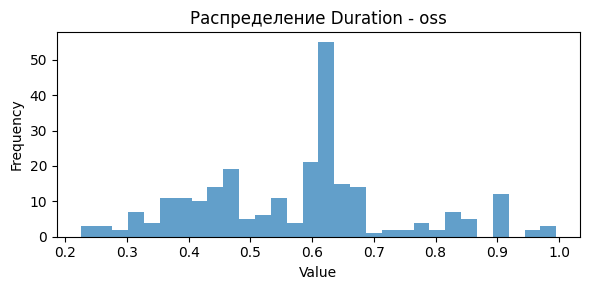

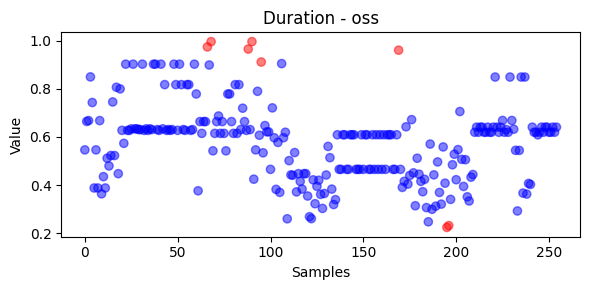

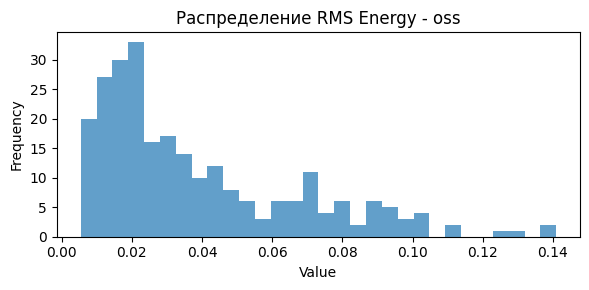

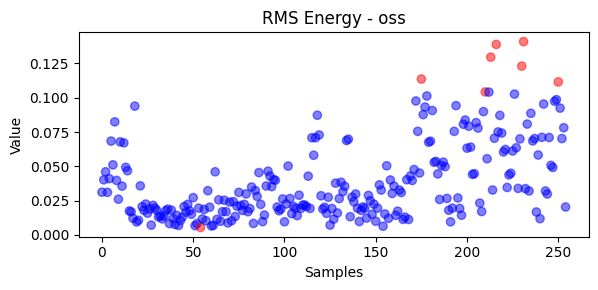

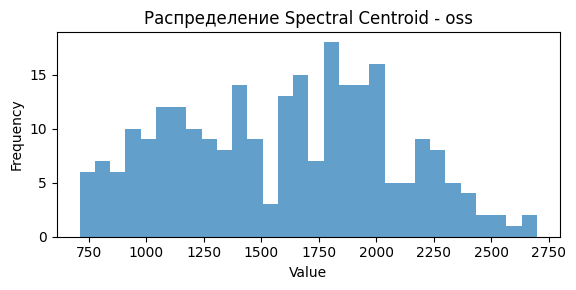

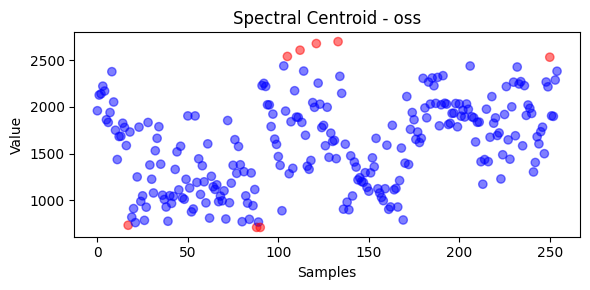

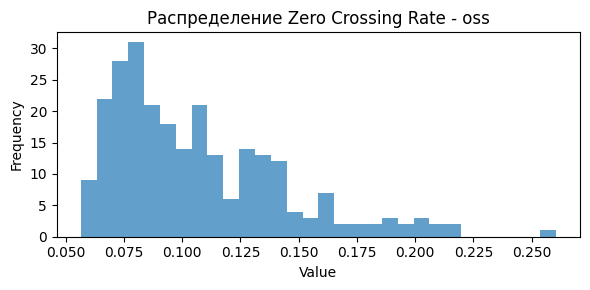

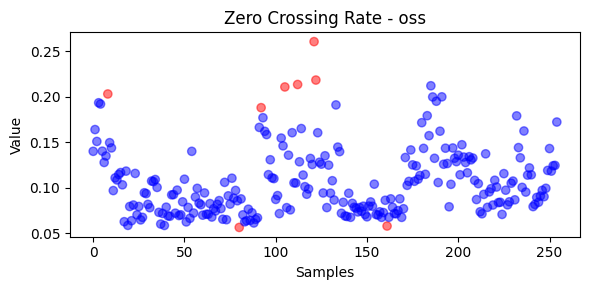


Категория: oss
  Всего файлов: 255
  Выбросов по признакам: 26
  Выброс обнаружен: oss/3_714.wav
  Выброс обнаружен: oss/20240209_183857_273.wav
  Выброс обнаружен: oss/20240209_182727_62.wav
  Выброс обнаружен: oss/20240209_181458_160.wav
  Выброс обнаружен: oss/20240209_181745_3_181.wav
  Выброс обнаружен: oss/20240209_182447_223.wav
  Выброс обнаружен: oss/20240209_182609_3_202.wav
  Выброс обнаружен: oss/20240209_181633_174.wav
  Выброс обнаружен: oss/3_743.wav
  Выброс обнаружен: oss/3_755.wav
  Выброс обнаружен: oss/fourth_1047.wav
  Выброс обнаружен: oss/fourth_1035.wav
  Выброс обнаружен: oss/fith_919.wav
  Выброс обнаружен: oss/fith_920.wav
  Выброс обнаружен: oss/nine_n_1438.wav
  Выброс обнаружен: oss/IMG_3476_467.wav
  Выброс обнаружен: oss/IMG_3469_425.wav
  Выброс обнаружен: oss/ten_n_1137.wav
  Выброс обнаружен: oss/sixth_1059.wav
  Выброс обнаружен: oss/sixth_1057.wav
  Выброс обнаружен: oss/Тайкеку соно ни 4_356.wav
  Выброс обнаружен: oss/Тайкеку соно ни 1_327.wav


In [ ]:
def extract_features(file_path):
    """Извлекает аудио-характеристики из файла."""
    audio, sr = librosa.load(file_path, sr=None)
    duration = len(audio) / sr
    rms_energy = np.mean(librosa.feature.rms(y=audio))
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    return [duration, rms_energy, spectral_centroid, zero_crossing_rate]

def detect_outliers_per_feature(features, feature_index):
    """Использует Isolation Forest для определения выбросов для отдельного признака."""
    scaler = StandardScaler()
    scaled_feature = scaler.fit_transform(features[:, feature_index].reshape(-1, 1))
    isol_forest = IsolationForest(contamination=0.03, random_state=42)
    predictions = isol_forest.fit_predict(scaled_feature)
    return predictions

def plot_feature(features, predictions, feature_index, feature_name, category):
    """Визуализирует отдельный признак с выделением выбросов."""
    plt.figure(figsize=(6, 3))
    colors = np.array(['blue' if pred == 1 else 'red' for pred in predictions])
    plt.scatter(range(len(features)), features[:, feature_index], c=colors, alpha=0.5)
    plt.title(f"{feature_name} - {category}")
    plt.ylabel('Value')
    plt.xlabel('Samples')
    plt.tight_layout()
    plt.show()

def plot_distribution(features, feature_index, feature_name, category):
    """Визуализирует распределение данных по признаку перед анализом."""
    plt.figure(figsize=(6, 3))
    plt.hist(features[:, feature_index], bins=30, alpha=0.7)
    plt.title(f"Распределение {feature_name} - {category}")
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    plt.tight_layout()
    plt.show()

def process_audio_files(input_directory, output_directory):
    """Обрабатывает аудиофайлы и копирует их без выбросов в новую директорию."""
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    feature_names = ['Duration', 'RMS Energy', 'Spectral Centroid', 'Zero Crossing Rate']
    overall_outlier_counts = {name: {} for name in feature_names}
    total_outlier_counts = {category: 0 for category in os.listdir(input_directory)}

    for category in os.listdir(input_directory):
        category_path = os.path.join(input_directory, category)
        if not os.path.isdir(category_path):
            continue

        features = []
        file_paths = []

        for filename in os.listdir(category_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(category_path, filename)
                file_features = extract_features(file_path)
                features.append(file_features)
                file_paths.append(file_path)

        if features:
            features = np.array(features)
            combined_predictions = np.ones(len(features), dtype=int)

            for feature_index, feature_name in enumerate(feature_names):
                plot_distribution(features, feature_index, feature_name, category)
                predictions = detect_outliers_per_feature(features, feature_index)
                plot_feature(features, predictions, feature_index, feature_name, category)

                outlier_count = np.sum(predictions == -1)
                overall_outlier_counts[feature_name][category] = outlier_count

                combined_predictions = np.logical_and(combined_predictions, predictions == 1)

            total_outlier_count = np.sum(combined_predictions == 0)
            total_outlier_counts[category] = total_outlier_count

            print(f"\nКатегория: {category}")
            print(f"  Всего файлов: {len(file_paths)}")
            print(f"  Выбросов по признакам: {total_outlier_count}")

            for index, file_path in enumerate(file_paths):
                if combined_predictions[index] == 0:
                    relative_path = os.path.relpath(file_path, input_directory)
                    print(f"  Выброс обнаружен: {relative_path}")
                else:
                    relative_path = os.path.relpath(file_path, input_directory)
                    new_path = os.path.join(output_directory, relative_path)
                    os.makedirs(os.path.dirname(new_path), exist_ok=True)
                    shutil.copy(file_path, new_path)

    # Вывод общей информации о выбросах по признакам
    print("\nОбщее количество выбросов по признакам и категориям:")
    for feature_name, category_counts in overall_outlier_counts.items():
        print(f"\nПризнак: {feature_name}")
        for category, count in category_counts.items():
            print(f"  {category}: {count} выбросов")

    # Вывод общей информации о выбросах по категориям
    print("\nОбщее количество выбросов по категориям:")
    for category, count in total_outlier_counts.items():
        print(f"{category}: {count} выбросов")

source_directory = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/trimmed_dataset'
clean_directory = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/cleaned_dataset_1'

# Обработка аудиофайлов
process_audio_files(source_directory, clean_directory)

In [ ]:
def analyze_dataset(folder_path):
    categories = sorted(os.listdir(folder_path))
    for category in categories:
        category_path = os.path.join(folder_path, category)
        files = os.listdir(category_path)
        durations = []
        for file in files:
            file_path = os.path.join(category_path, file)
            audio, _ = librosa.load(file_path, sr=16000, mono=True)
            durations.append(len(audio) / 16000)  # Преобразование в секунды

        total_duration = sum(durations)
        print(f"Category: {category}, Files: {len(files)}, Total Duration: {total_duration:.2f} sec")

# Использование функции для анализа датасета
dataset_dir = '/content/cleaned_dataset_1'
analyze_dataset(dataset_dir)

Category: hadgime, Files: 159, Total Duration: 87.81 sec
Category: kato1, Files: 120, Total Duration: 120.33 sec
Category: kato2, Files: 119, Total Duration: 114.14 sec
Category: kato3, Files: 135, Total Duration: 133.97 sec
Category: kato4, Files: 131, Total Duration: 124.15 sec
Category: kiai, Files: 342, Total Duration: 227.74 sec
Category: naure, Files: 152, Total Duration: 89.88 sec
Category: oss, Files: 212, Total Duration: 121.20 sec


# Анализ и стратификация:

In [ ]:
# Функция создает dataframe c длительностью и громкостью по аудио
def audio_statistics(dataset_dir):
  sliced_audio_data_list = []
  for label in os.listdir(dataset_dir):
    audio_folder = os.path.join(dataset_dir, label)
    for audio_name in os.listdir(audio_folder):
      audio_path = os.path.join(audio_folder, audio_name)
      audio = AudioSegment.from_file(audio_path)
      duration_in_milliseconds = len(audio)
      duration_in_seconds = duration_in_milliseconds / 1000.0
      loudness = audio.dBFS
      sliced_audio_data = {'audio_name': audio_name,
                           'audio_path': audio_path,
                           'duration (s)': duration_in_seconds,
                           'loudness (dB)': loudness,
                           'label': label
                           }
      sliced_audio_data_list.append(sliced_audio_data)
  df = pd.DataFrame(sliced_audio_data_list)

  # проверяем количество примеров по лейблам:
  print("Статистика датасета:")
  display(df.groupby(['label']).audio_path.count())
  # Статистика по громкости аудио:
  print("\nСтатистика  по громкости аудио:")
  display(df.groupby('label').agg({'loudness (dB)': ['min', 'mean', 'max']}))
  # Статистика по длительности аудио:
  print("\nСтатистика  по длительности аудио:")
  display(df.groupby('label').agg({'duration (s)': ['min', 'mean', 'max']}))

  return df


dataset_dir = '/content/drive/MyDrive/Стажировка "Кёкусинкай"/cleaned_dataset_1'
df = audio_statistics(dataset_dir)

Видно, что в датасете большой разброс по громкости и длительности аудио. Для улучшения обучения модели, разобьем данные на группы по громкости и длительности, результат добавим в столбец 'group'. Потом по этому столбцу и столбцу с названием клича будем проводить стратификацию данных при разбиении датасета на выборки.

Разобъем аудио по на 4 группы: меньше среднего значения - тихое, короткое;
больше или равно среднего - громкое, длинное.

In [ ]:
# Классификация каждого аудио по длине и громкости (варинат 2)
def classify_loudness_duration(row):

  # Вычисляем средние значения длины и громкости для каждого клича:
  mean_loudness = df.groupby('label')['loudness (dB)'].mean()
  mean_duration = df.groupby('label')['duration (s)'].mean()

  # Получение средних значений по label для конкретной строки
  label_mean_loudness = mean_loudness[row['label']]
  label_mean_duration = mean_duration[row['label']]

  # Классификация по длительности
  if row['duration (s)'] < label_mean_duration:
    dur_label = 'short'
  else:
    dur_label = 'long'

  # Классификация по громкости
  if row['loudness (dB)'] < label_mean_loudness:
    vol_label = 'quiet'
  else:
    vol_label = 'loud'

  return f"{dur_label}_{vol_label}"

In [ ]:
# Добавление нового столбца 'group' с классификацией
df['group'] = df.apply(classify_loudness_duration, axis=1)

# Комбинирование названия клича и группы для стратификации
df['strata'] = df['label'] + "_" + df['group']
df

,audio_name,audio_path,duration (s),loudness (dB),label,group,strata
0,seven_n_1299.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.370,-39.730665,oss,short_quiet,oss_short_quiet
1,ten_n_1114.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.672,-19.094133,oss,long_loud,oss_long_loud
2,Тайкеку соно сан 1_384.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.620,-20.135711,oss,long_loud,oss_long_loud
3,Тайкеку соно сан 1_383.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.641,-22.250022,oss,long_loud,oss_long_loud
4,Тайкеку соно ни 5_349.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.620,-21.560330,oss,long_loud,oss_long_loud
...,...,...,...,...,...,...,...
1451,Тайкеку соно сан 1_389.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.754,-19.694762,naure,long_loud,naure_long_loud
1452,Тайкеку соно ни 3_368.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.722,-19.687088,naure,long_loud,naure_long_loud
1453,Тайкеку соно ни 4_361.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.754,-19.805510,naure,long_loud,naure_long_loud
1454,Тайкеку соно ни 2_375.wav,"/content/drive/MyDrive/Стажировка ""Кёкусинкаи...",0.722,-22.243156,naure,long_loud,naure_long_loud


In [ ]:
# Разбиваем dataframe на выборки, со стратификацией по столбцу 'strata'
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['strata'], random_state=0)

In [ ]:
# Построение диаграммы разбиения по выборкам
def visualize_train_valid_distribution(train_data, val_data, column='label'):
    train_labels = train_data[column]
    val_labels = val_data[column]
    fig, ax = plt.subplots(figsize=(12, 5))

    # Распределение вхождений в классы на наборах данных
    class_totals = train_labels.value_counts().add(val_labels.value_counts(), fill_value=0)
    train_counts = train_labels.value_counts().reindex(class_totals.index, fill_value=0)
    val_counts = val_labels.value_counts().reindex(class_totals.index, fill_value=0)

    x = np.arange(len(class_totals))  # the label locations
    width = 0.25  # the width of the bars

    ax.bar(x - width, train_counts, width, label='Train')
    ax.bar(x, val_counts, width, label='Validation')

    # Adding counts above bars
    for i, rect in enumerate(ax.containers):
        ax.bar_label(rect, labels=[f'{x/class_totals[idx]*100:.1f}%' for idx, x in enumerate(rect.datavalues)], label_type='edge', rotation=45)

    ax.set_title('Распределение вхождений в классы на наборах данных')
    ax.set_xlabel('Классы')
    ax.set_ylabel('Количество вхождений')
    ax.set_xticks(x)
    ax.set_xticklabels(class_totals.index, rotation=45)
    ax.legend()

    plt.show()

visualize_train_valid_distribution(train_df, val_df)

In [ ]:
# Перевод в numpy массив
x_train_data = np.array(train_df['audio_path'])
y_train_data = np.array(train_df['label'])
x_val_data = np.array(val_df['audio_path'])
y_val_data = np.array(val_df['label'])

In [ ]:
# Загрузка и извлечение признаков из аудио
def load_and_extract_features(audio_paths):
  # Загрузка аудио файла
  features = []
  for audio_path in audio_paths:
    audio, sr = librosa.load(audio_path, sr=22050)

    # Извлечение MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mfccs_mean = np.mean(mfccs, axis=1)

    # Извлечение Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(audio)
    zcr_mean = np.mean(zcr)

    # Извлечение спектральной ширины
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)

    # Извлечение спектрального центроида
    spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)

    # Извлечение RMS
    rms = librosa.feature.rms(y=audio)
    rms_mean = np.mean(rms)

    # Собираем все признаки в один массив
    audio_features = np.hstack((mfccs_mean, zcr_mean, spectral_bandwidth_mean, spectral_centroid_mean, rms_mean))
    features.append(audio_features)

  features = np.array(features)
  return features

In [ ]:
# Подготовка Y:
# Создание экземпляра LabelEncoder
encoder = LabelEncoder()

labels_list = np.unique(y_train_data)
labels_count = len(labels_list)

# Обучение LabelEncoder на данных метках
encoded_labels = encoder.fit_transform(labels_list)

# Переводим названия кличей в номер класса
y_train = encoder.transform(y_train_data)
y_val = encoder.transform(y_val_data)

# Подготовка X:
# Извлекаем признаки из аудио, формируем выборки с эмбеддингами
x_train = load_and_extract_features(x_train_data)
x_val = load_and_extract_features(x_val_data)

print(f'{x_train.shape}, {y_train.shape}')
print(f'{x_val.shape}, {y_val.shape}')

(1164, 44), (1164,)
(292, 44), (292,)


In [ ]:
#Нормализация признаков
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
# Сохраняем скалер в файл
import pickle

# scaler - это экземпляр StandardScaler, который вы использовали для нормализации данных
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Обучение модели

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Отслеживание изменения функции потерь на валидации
    patience=15,         # Количество эпох с отсутствием улучшения после которых обучение будет остановлено
    restore_best_weights=True,  # Восстанавливает веса модели из эпохи с лучшей производительностью
    verbose=1
)

# Функция для обучения модели, построения графиков обучения, анализа результатов
def train_analysis_model(model,
                         x_train,
                         y_train,
                         x_val,
                         y_val,
                         x_test,
                         y_test,
                         epochs=100,
                         optimizer='adam',
                         labels_list=labels_list
                         ):

  model.summary()
  model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stopping])

  # Вывод графиков обучения
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
  ax1.plot(history.history['loss'], label='Ошибка на обучающем наборе')
  ax1.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
  ax1.set_xlabel('Эпоха обучения')
  ax1.set_ylabel('Ошибка')
  ax1.legend()
  ax1.set_title('== График ошибки ==')

  ax2.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
  ax2.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
  ax2.set_xlabel('Эпоха обучения')
  ax2.set_ylabel('Доля верных ответов')
  ax2.legend()
  ax2.set_title('== График точности ==')

  plt.show()

  # Прогнозирование моделью
  predict = model.predict(x_test, verbose=0)
  y_pred = np.argmax(predict, axis=1)

  # Оценка результатов
  accuracy = np.sum(y_pred == y_test) / len(y_test)
  print(f'Test accuracy: {accuracy * 100:.2f}%')

  # Confusion Matrix:
  cm = confusion_matrix(y_test, y_pred)
  disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
  fig.autofmt_xdate(rotation=45)
  disp1.plot(colorbar=False)
  plt.show()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 1024)              46080     
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 dense_36 (Dense)            (None, 512)               524800    
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_37 (Dense)            (None, 8)                 4104      
                                                                 
Total params: 574984 (2.19 MB)
Trainable params: 574984 (2.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
37/37

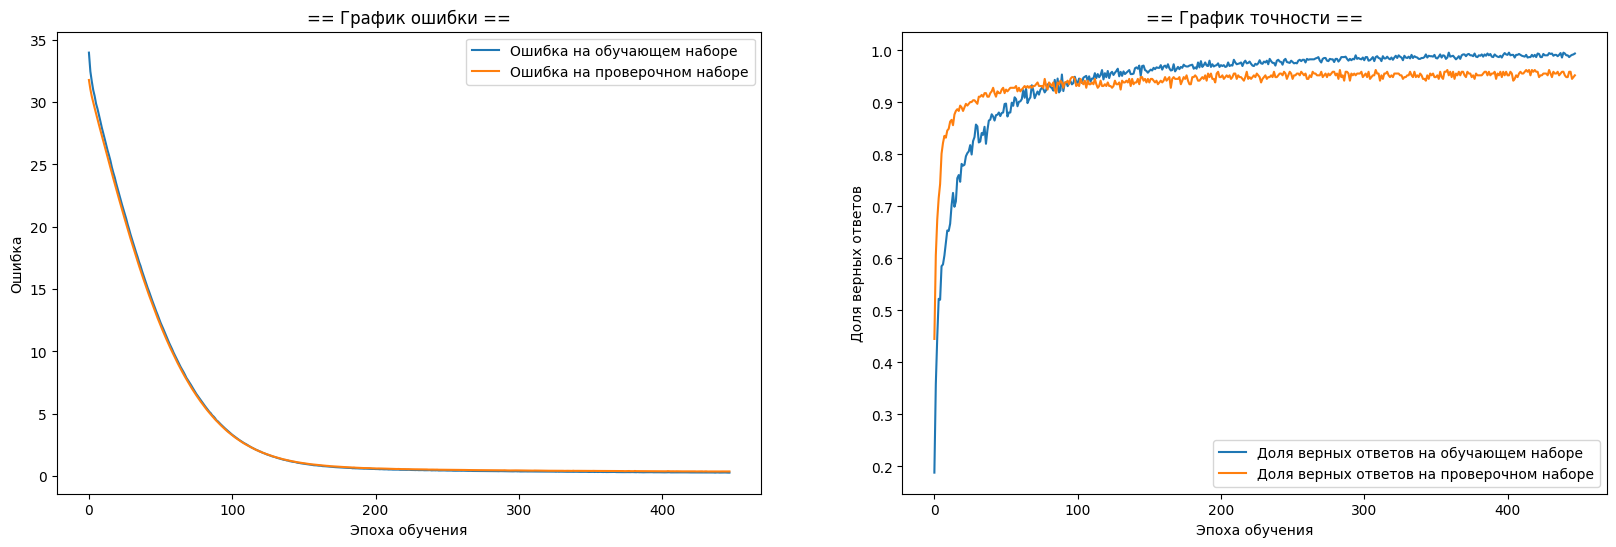

Test accuracy: 95.89%


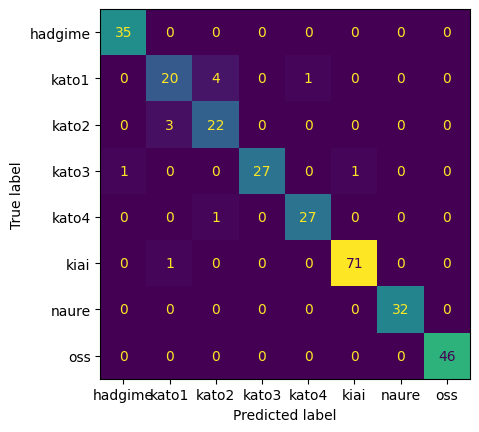

In [ ]:
model_l_1 = Sequential()

# Добавление первого полносвязного слоя с регуляризацией L2 и инициализатором He
model_l_1.add(Dense(1024, input_dim=x_train.shape[1], activation='relu',
                    kernel_regularizer=l2(0.01), kernel_initializer='he_normal'))
model_l_1.add(Dropout(0.5))  # Добавление слоя Dropout для регуляризации

# Добавление второго полносвязного слоя с регуляризацией L2
model_l_1.add(Dense(512, activation='relu',
                    kernel_regularizer=l2(0.01), kernel_initializer='he_normal'))
model_l_1.add(Dropout(0.5))  # Добавление слоя Dropout для регуляризации

# Выходной слой с функцией активации softmax для классификации
model_l_1.add(Dense(labels_count, activation='softmax'))

train_analysis_model(model_l_1, x_train_scaled, y_train, x_val_scaled, y_val, x_val_scaled, y_val, epochs=500, optimizer=Adam(learning_rate=0.0001))

In [ ]:
# Сохраним модель на гугл диск
os.chdir('/content')
model_name = 'best_model_librosa_6'
model_l_1.save(model_name)
!cp -r /content/{model_name} '/content/drive/MyDrive/Стажировка "Кёкусинкай"'

In [ ]:
model_l_1.save('best_model_librosa.h5')  # Сохранение модели в формате HDF5